#WASSERSTEIN GAN :

ce notebook n'est qu'une tentative, il n'est pas définitif

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
from keras.datasets.mnist import load_data
(x_train, y_train), (x_test, y_test) = load_data()

print("train", x_train.shape, y_train.shape)
print("train", x_test.shape, y_test.shape)

11501568/11490434 [==============================] - 0s 0us/step
train (60000, 28, 28) (60000,)
train (10000, 28, 28) (10000,)


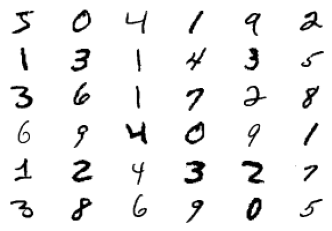

In [ ]:
from matplotlib import pyplot
for i in range(36):
  pyplot.subplot(6,6,1+i)
  pyplot.axis('off')
  pyplot.imshow(x_train[i], cmap='gray_r')

#ne garder que les 0, 1 et 2

In [ ]:
def load_012():
  (x_train,y_train), (_, _) = load_data()
  zz=np.zeros(len(y_train))
  idxz = np.where(y_train==zz)
  oo=np.ones(len(y_train))
  idxo = np.where(y_train==oo)
  dd=2*np.ones(len(y_train))
  idxd = np.where(y_train==dd)

  index = np.hstack([idxz[0],idxo[0],idxd[0]])
  sub_train = x_train[index]
  return sub_train,y_train[index]


18623


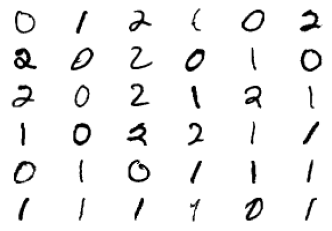

In [ ]:
from matplotlib import pyplot
x_train,y_train = load_012()
print(len(x_train))
i=0
x=np.random.choice(range(len(x_train)), 36)
for index in x:
  pyplot.subplot(6,6,1+i)
  i+=1
  pyplot.axis('off')
  pyplot.imshow(x_train[index], cmap='gray_r')

#DISCRIMINATOR

In [ ]:
#wasserstein loss
from keras import backend
def wasserstein_loss(y_true, y_pred):
  return backend.mean(y_true * y_pred)

In [ ]:
class ClipConstraint:
  def __init__(self, clip_value):
    self.clip_value = clip_value
  
  def __call__(self, weights):
    return backend.clip(weights, -self.clip_value, self.clip_value)

  def get_config(self):
    return {"clip_value":self.clip_value}

In [ ]:
# example of defining the discriminator model

from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from keras.initializers import RandomNormal
from keras.utils.vis_utils import plot_model

def define_discriminator(in_shape=(28,28,1)):
  const=ClipConstraint(0.01)

  init = RandomNormal(stddev=0.02)

  model = Sequential()
  model.add(Conv2D(16, (4,4), strides=(2,2), padding='same', kernel_initializer=init,kernel_constraint=const, input_shape=in_shape))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.2))
  model.add(Conv2D(10, (3,3), strides=(2,2), padding='same', kernel_initializer=init, kernel_constraint=const))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.2))
  model.add(Flatten())
  #Flatten : returns sequential version of 2D matrix/result of conv
  model.add(Dense(1, activation='linear'))
  #dense : ici une seule unité, qui prend les 7x7 inputs du layer avant et sort une proba
  
  opt = RMSprop(lr=0.00005)
  #adam : un optimisateur de descente de gradient, qui change lr pour aller plus vite au min
  model.compile(loss=wasserstein_loss, optimizer=opt, metrics=['accuracy'])

  return model

In [ ]:
model = define_discriminator()

model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 13, 13, 16)        272       
                                                                 
 batch_normalization_28 (Bat  (None, 13, 13, 16)       64        
 chNormalization)                                                
                                                                 
 leaky_re_lu_34 (LeakyReLU)  (None, 13, 13, 16)        0         
                                                                 
 dropout_28 (Dropout)        (None, 13, 13, 16)        0         
                                                                 
 conv2d_31 (Conv2D)          (None, 7, 7, 10)          1450      
                                                                 
 batch_normalization_29 (Bat  (None, 7, 7, 10)         40        
 chNormalization)                                    

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


data definition/loading/creation functions :

In [ ]:
from numpy.random.mtrand import randint, rand
from numpy import expand_dims
def load_dataset():
  x_train,_ = load_012()
  X = expand_dims(x_train, axis=-1)
  X = X.astype('float32')
  X = X/255.0
  return X

def generate_real_samples(dataset, n_samples):
  #get random indices
  idx = randint(0, dataset.shape[0], n_samples)
  #sample according to indices
  X = dataset[idx]
  #create labels
  y = -np.ones((n_samples, 1)).astype('float64')
  return X,y

def generate_fake_samples(n_samples):
  #rand is already between 0 and 1
  X = rand(28*28*n_samples)
  X = X.reshape((n_samples, 28, 28))
  y = np.ones((n_samples, 1)).astype('float64')
  return X,y

In [ ]:
def train_discriminator(model, dataset, n_iter=1000, s_batch=256):
  accfake = []
  accreal = []
  for i in range(n_iter):
    s_half_batch = int(s_batch/2)
    #sample real examples
    X_real, y_real = generate_real_samples(dataset, s_half_batch)
    realloss, realacc = model.train_on_batch(X_real, y_real)
    #sample fake examples
    X_fake, y_fake = generate_fake_samples(s_half_batch)
    fakeloss, fakeacc = model.train_on_batch(X_fake, y_fake)

    

    if(i%100==0):
      print(i+1, " : \nrealacc : ", realacc*100, "\nfakeacc : ", fakeacc*100, '\n')

    if(i%100==0):
      print(i+1, " : \nrealloss : ", realloss*100, "\nfakeloss : ", fakeloss*100, '\n')

In [ ]:
model = define_discriminator()


accuracies = train_discriminator(model, load_dataset())

ci-dessous : pour un vrai, il a prédit 0.006 ?
pour un fake, -0.100 ??
Avec la batchnormalisation, c'est presque pareil.

Essayer néanmoins de faire le GAN, peut-être que wasserstein pas fait pour traiter du bruit ?

Ou si ça ne marche pas il faut revoir la structure..

In [ ]:
X_real, y_real = generate_real_samples(load_dataset(), 1)
X_fake, y_fake = generate_fake_samples(1)

print(model.predict(X_fake))
print(model.predict(X_real))

[[-12.421125]]
[[6.8358383]]


#GENERATOR



*   has a latent space as input, to which it will slowly start attributing meaning.
*   first layer is a dense with 7x7xn units, which is then reshaped into 7x7 squares for next layer which is convolution. Each 7x7 represents a low-level image, a "feature map"

In [ ]:
from keras.layers import Reshape
from keras.layers import Conv2DTranspose

def define_generator(latent_dim):

  init = RandomNormal(stddev=0.02)

  model = Sequential()
  #transform the latent space into 10 7x7 low-res images
  model.add(Dense(10*7*7, kernel_initializer=init, input_dim=100))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Reshape((7,7,10)))
  #conv2DTranspose is the same as upsampling followed by convolution
  model.add(Conv2DTranspose(10, (4,4), strides=(2,2), kernel_initializer=init, padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(BatchNormalization())

  model.add(Conv2DTranspose(10, (4,4), strides=(2,2), kernel_initializer=init, padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(BatchNormalization())
  #make the final image
  model.add(Conv2D(1, (7,7), activation='tanh', padding='same', kernel_initializer=init))
  return model

In [ ]:
model = define_generator(100)
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 490)               49490     
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 490)               0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 10)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 10)       1610      
 nspose)                                                         
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 14, 14, 10)        0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 10)       1610      
 ranspose)                                            

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


using the discriminator :

In [ ]:
import numpy.matlib

def make_vectors(latent_dim, n_samples):
  samples = np.matlib.randn(n_samples * latent_dim)
  return samples.reshape(n_samples, latent_dim)

In [ ]:
def generate_generator_images(g_model,n_samples, latent_dim):
  vectors = make_vectors(latent_dim, n_samples)
  X = g_model.predict(vectors)
  #sans ce reshape on a du 28,28,1 pour les images
  X = X.reshape((n_samples,28,28))

  print("images ------- shape of X : ",X.shape)
  return X

images ------- shape of X :  (20, 28, 28)


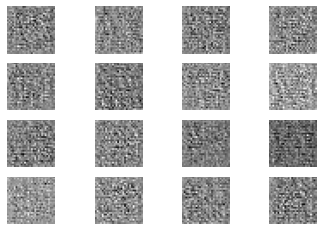

In [ ]:
g_model = define_generator(100)
X = generate_generator_images(g_model,20, 100)
for i in range(16):
  pyplot.subplot(4,4,1+i)
  pyplot.axis('off')
  pyplot.imshow(X[i], cmap='gray_r')
#voir le warning

#Adding the 2 together :



*   loss computed at output of discriminator.
*   the discriminator stays with default weights all along.
*   Then how can there be more error on fake samples than on real ones ? since discriminator not trained ? Why is it even adversarial then ?



In [ ]:
def define_gan(g_model, c_model):
  d_model.trainable=False
  model = Sequential()
  model.add(g_model)
  model.add(d_model)
  #Adam beta_1 : initial decay rate (so how the lr changes ?)
  opt = RMSprop(lr=0.00005)
  model.compile(loss=wasserstein_loss, optimizer=opt)
  return model

In [ ]:
(data,_),(_,_)= load_data()

d_model = define_discriminator()
#train_discriminator(d_model, load_dataset(), n_iter=50)

g_model = define_generator(100)

gan_model = define_gan(g_model, d_model)



/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [ ]:
gan_model.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_23 (Sequential)  (None, 28, 28, 1)         53281     
                                                                 
 sequential_22 (Sequential)  (None, 1)                 2317      
                                                                 
Total params: 55,598
Trainable params: 53,241
Non-trainable params: 2,357
_________________________________________________________________


In [ ]:
dloss = []
gloss = []

def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=256):
  bat_per_epo = int(int(dataset.shape[0])/n_batch)
  half_batch = int(n_batch/2)
  for i in range(n_epochs):
    for j in range(bat_per_epo):
      for l in range(5):
        X_real, y_real = generate_real_samples(dataset, half_batch)
        X_fake, y_fake = generate_generator_samples(g_model, half_batch, latent_dim)
        X= np.vstack((X_real, X_fake))
        y=np.vstack((y_real, y_fake))
        d_loss,_ = d_model.train_on_batch(X,y)

      X_gan = make_vectors(latent_dim, n_batch)
      y_gan = -np.ones((n_batch,1))

      g_loss = gan_model.train_on_batch(X_gan, y_gan)
      print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))
      dloss.append(d_loss)
      gloss.append(g_loss)
    #print images every epoch to follow progress
    X = generate_generator_images(g_model, 16, 100)
    for i in range(16):
      pyplot.subplot(4,4,1+i)
      pyplot.axis('off')
      pyplot.imshow(X[i], cmap='gray_r')
    pyplot.show()

In [ ]:

#version sans le reshape
def generate_generator_samples(g_model,n_samples, latent_dim):
  vectors = make_vectors(latent_dim, n_samples)
  X = g_model.predict(vectors)
  y= np.ones((n_samples, 1))
  return X,y

In [ ]:
dataset = load_dataset()
train(g_model,d_model, gan_model, dataset, 100, n_epochs=100)

In [ ]:
X,y = generate_generator_images(g_model,20, 100)
for i in range(16):
  pyplot.subplot(4,4,1+i)
  pyplot.axis('off')
  pyplot.imshow(X[i], cmap='gray_r')

In [ ]:
shapedd = np.array(dloss).reshape((30,72))
shapeddmeans = [np.mean([val for val in ep])for ep in shapedd]
shapeddmeans

shapedg = np.array(gloss).reshape((30,72))
shapedgmeans = [np.mean([val for val in ep])for ep in shapedg]
shapedgmeans

In [ ]:
for i in range(5,95):
  shapeddmeans[i]=np.mean([shapeddmeans[i-3],shapeddmeans[i-2],shapeddmeans[i-1],shapeddmeans[i],shapeddmeans[i+1],shapeddmeans[i+2],shapeddmeans[i+3]])

In [ ]:
plt.figure(figsize=(15,5))
plt.axes().set(facecolor=(.6,.7,.9,1.))
plt.plot(range(100), shapeddmeans, color=(.8,1.,.6,1.),label='discriminateur')
plt.plot(range(100), shapeddmeans,'o', color=(.8,1.,.6,1.))


plt.plot(range(100), shapedgmeans, color=(1.,0.8,.6,1.),label='generateur')
plt.plot(range(100), shapedgmeans,'o', color=(1.,0.8,.6,1.))

plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss (binary cross entropy)")
plt.grid(axis="both", linewidth=2, color=(.45,.55,.75,1.))
plt.title("évolution de la fonction de coût des deux modèles (petit GAN)")

plt.show()

In [ ]:
bigGanD = [0.647,0.348,0.068,0.026,0.44,1.08,0.698,0.539,0.73,0.69,0.763,0.725,0.705,0.706,0.689,0.684,0.696,0.7]
bigGanG = [0.859,1.08,2.633,3.912,1.323,1.07,0.745,0.827,0.705,0.735,0.759,0.704,0.722,0.710,0.674,0.726,0.702,0.740]

plt.figure(figsize=(15,5))
plt.axes().set(facecolor=(.6,.7,.9,1.))
plt.plot(range(len(bigGanG)), bigGanD, color=(.8,1.,.6,1.),label='discriminateur')
plt.plot(range(len(bigGanG)), bigGanD,'o', color=(.8,1.,.6,1.))

plt.plot(range(len(bigGanG)), bigGanG, color=(1.,0.8,.6,1.),label='generateur')
plt.plot(range(len(bigGanG)), bigGanG,'o', color=(1.,0.8,.6,1.))

plt.legend()
plt.xticks(range(len(bigGanG)))
plt.xlabel("epochs")
plt.ylabel("loss (binary cross entropy)")
plt.grid(axis="both", linewidth=2, color=(.45,.55,.75,1.))
plt.title("évolution de la fonction de coût des deux modèles")

plt.show()

In [ ]:
#(récupérer les données)
X_real, y_real = generate_real_samples(load_dataset(), 1)
X_fake, y_fake = generate_fake_samples(1)

In [ ]:
tempmodel = Sequential()
tempmodel.add(d_model.get_layer(index=0))
tempmodel.add(d_model.get_layer(index=1))

predreal = tempmodel.predict(X_real)
predfake = tempmodel.predict(X_fake)

In [ ]:
tempmodel.summary()

Activation du discriminateur associée à un vrai

In [ ]:
for i in range(25):
  img = predreal.reshape((25,28,28))[i]
  pyplot.subplot(5,5,1+i)
  pyplot.imshow(img, cmap='gray_r')
pyplot.show()

activation associée à un faux :

In [ ]:
for i in range(25):
  img = predfake.reshape((25,28,28))[i]
  pyplot.subplot(5,5,1+i)
  pyplot.imshow(img, cmap='gray_r')
pyplot.show()